# Group Members:
*   Batuhan Uzun - 070170075
*   Özge Yılmaz - 070180029
*   Şükran Han - 070180128
*   Taha Galata - 070190002
*   Teoman İnan - 070180033

# Aim of the Project
To create a model which can predict downloads from Google Play Game data.

# Importing Libraries & Data

In [ ]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
import tensorflow as tf
import math

We've used Samet Çopur's web scraping data since it has the most number of games and features.

In [ ]:
data = pd.read_csv("data.csv", index_col=0)
data.head(1)

,Name,Number of Rating,Genre,Rating,Price,Description,Updated,Size,Installs,Current Version,Requires Android,Content Rating,Offered By,Interactive Elements,In-app Products
ID,,,,,,,,,,,,,,,
0,Geometry Dash Lite,"7,227,039",Arcade,4.4,0,Jump and fly your way through danger in this r...,11-Dec-19,58M,"100,000,000+",2.2,4.0 and up,Everyone,RobTop Games,NaN,NaN


# Preprocessing of Non-Image Data

## In-app Products Data Preprocessing

We have removed "per item" and "$".

In [ ]:
data["In-app Products"] = data["In-app Products"].astype("string")

In [ ]:
data["In-app Products"] = data["In-app Products"].str.replace(" per item", "")

In [ ]:
data["In-app Products"] = data["In-app Products"].str.replace("$", "")

In [ ]:
data["In-app Products"].fillna("0 - 0", inplace=True)

Then we have splitted the range into minimum and maximum values.

In [ ]:
data["Min In_app Products"] = data["In-app Products"].str.split(" - ", expand=True).astype("float32").iloc[:, 0]

In [ ]:
data["Max In_app Products"] = data["In-app Products"].str.split(" - ", expand=True).astype("float32").iloc[:, 1]

Lastly, we have dropped unprocessed column.

In [ ]:
data.drop("In-app Products", axis=1, inplace=True)

## Interactive Elements Preprocessing

In [ ]:
data["Interactive Elements"].unique()

array([nan, 'Digital Purchases', 'Users Interact, Digital Purchases',
       'In-Game Purchases', 'Users Interact, In-Game Purchases',
       'Shares Location, Digital Purchases', 'Users Interact',
       'Shares Info, Digital Purchases',
       'In-Game Purchases (Includes Random Items)',
       'Users Interact, In-Game Purchases (Includes Random Items)',
       'In-App Purchases',
       'Users Interact, Shares Info, Digital Purchases',
       'Users Interact, Shares Info, Shares Location, Digital Purchases',
       'Shares Location, In-Game Purchases',
       'Users Interact, Shares Location, In-Game Purchases',
       'Users Interact, In-App Purchases',
       'Users Interact, Shares Location, Digital Purchases',
       'Shares Info', 'Users Interact, Shares Location'], dtype=object)

We have filled nan values with the string "None"

In [ ]:
data["Interactive Elements"].fillna("None", inplace=True)

There were more than one element in one string of each "Interactive Elemenents" data. We have seperated those strings to get individual elements.

In [ ]:
elements = []
for string in data["Interactive Elements"].unique()[1: ]:
    for element in string.split(", "):
        if element not in elements:
            elements.append(element)
elements

['Digital Purchases',
 'Users Interact',
 'In-Game Purchases',
 'Shares Location',
 'Shares Info',
 'In-Game Purchases (Includes Random Items)',
 'In-App Purchases']

Then, we have checked each game if they have the elements above. If there is, we have denoted respective element's value as 1, 0 otherwise.

In [ ]:
for element in elements:
    data[element] = 0
    for i in range(data.shape[0]):
        data.at[i, element] = int(element in data.loc[i, "Interactive Elements"])

Lastly, we have dropped unprocessed column.

In [ ]:
data.drop("Interactive Elements", axis=1, inplace=True)

## Offered By Preprocessing

We have grouped the games according to their producers. Then we've counted how many games are produced by each producer. Then, it is converted to a dictionary.

In [ ]:
producers = data.groupby(by="Offered By").count()["Name"].to_dict()

Then, we have added these counted games to the "Number of Games Offered By Producer" column.

In [ ]:
for i in range(data.shape[0]):
    key = data.loc[i, "Offered By"]
    data.loc[i, "Number of Games Offered By Producer"] = producers[key]

Lastly, we have dropped unprocessed column.

In [ ]:
data.drop("Offered By", axis=1,inplace=True)

## Size Data Preprocessing

Data Sizes were in such form: "99M", "1.5G", "Varies with device"

In [ ]:
data["Size"] = data["Size"].str.replace(",", "")

We have removed M and G, replaced "varies with device" with 0. We have kept the sizes with Gs in a list so that we can multiply these with 1024 to convert to megabytes. 

In [ ]:
G_list=[]
data["Size"]=data["Size"].str.replace("M", "")
data["Size"]=data["Size"].str.replace("Varies with device", "0")
for i in range(data.shape[0]):
    if "G" in data.loc[i,"Size"]:
        G_list.append(i)
data["Size"]=data["Size"].str.replace("G", "")
data["Size"]=data["Size"].astype("float32")

In [ ]:
data["Max In_app Products"].fillna(0,inplace=True)

In [ ]:
print(G_list)

[348, 394, 550, 616, 691, 775, 1402, 1514, 1546, 1659, 1739, 1958, 2090, 2239]


In [ ]:
for i in range(data.shape[0]):
    if i in G_list:
      data.loc[i,"Size"]=data.loc[i,"Size"]*1024

Lastly, we have assigned sizes "varies with device" to the average.

In [ ]:
average=data["Size"].sum()/(2368-205)
for i in range(data.shape[0]):
    if data.loc[i,"Size"]==0: # varies with device was changed to 0 before
        data.loc[i,"Size"]=average

## Requires Android Preprocessing

In [ ]:
data["Requires Android"] = data["Requires Android"].astype("string")

We have removed " and up" and get the minimum android version required.

In [ ]:
data["Requires Android"] = data["Requires Android"].str.replace(" and up", "")

In [ ]:
data["Requires Android"].replace({'4.4W':'4.4', 
                                  '5.1 - 12': '5.1',
                                  '2.3.3': '2.33',
                                  '4.0.3': '4.03',
                                  'Varies with device': data["Requires Android"].mode()[0]
                                 }, inplace=True)

In [ ]:
data["Requires Android"] = data["Requires Android"].astype("float32")

## Price Data Preprocessing

We have removed $ sign and space.

In [ ]:
data["Price"] = data["Price"].astype("string")

In [ ]:
data["Price"]=data["Price"].str.replace("$", "")

In [ ]:
data["Price"]=data["Price"].str.replace(" ", "")
data["Price"].unique()

<StringArray>
[    '0',  '3.99',  '9.99',  '4.99', '15.99',  '6.99',  '5.49',  '2.99',
  '7.49',  '2.49',  '1.99',  '0.99',  '7.99',  '3.49', '13.99',  '6.49',
  '4.49',  '5.99', '19.99',  '8.99',  '1.49',  '8.49',  '0.49', '32.99']
Length: 24, dtype: string

## Genre Preprocessing

We have used one hot encoding for the genre data.

In [ ]:
data["Genre"].unique()

array(['Arcade', 'Action', 'Simulation', 'Board', 'Strategy', 'Casual',
       'Role Playing', 'Educational', 'Puzzle', 'Sports', 'Casino',
       'Card', 'Racing', 'Adventure', 'Music', 'Word', 'Trivia'],
      dtype=object)

In [ ]:
data = pd.get_dummies(data,prefix="Genre",columns=["Genre"])

## Updated Preprocessing

We have converted updated date data to a pandas datetime object.

In [ ]:
data['Updated'] = pd.to_datetime(data['Updated'])

Then, calculated how many days ago the game was updated.

In [ ]:
delta = pd.Timestamp.today() - data['Updated']
data['Updated x Days Ago'] = delta.dt.days

In [ ]:
data.drop("Updated", axis=1, inplace=True)

## Content Rating Preprocessing

We have split the content rating string to individual ratings.

In [ ]:
ratings = []
for string in data["Content Rating"].unique():
    for rating in string.split(", "):
        for i in rating.split(","):
            if i not in ratings:
                ratings.append(i)

Then, we have categorized and sorted the ratings into 7 main categories. Bigger the index, higher the number it takes.

In [ ]:
rating_categories = {
    "Age" : ['Everyone','Everyone 10+','Teen', 'Mature 17+'],
    "Violance": ['Cartoon Violence', 'Violent References', 'Mild Fantasy Violence','Fantasy Violence','Mild Violence', 'Violence', 'Intense Violence','Mild Blood', 'Blood', 'Blood and Gore'],
    "Language": ['Mild Lyrics', 'Mild Language', 'Language', 'Strong Language'],
    "Sexual": ['Partial Nudity', 'Nudity', 'Sexual Themes', 'Sexual Content','Strong Sexual Content'],
    "Gambling": ['Simulated Gambling',],
    "Others": ['Mild Suggestive Themes', 'Suggestive Themes', 'Comic Mischief', 'Crude Humor']
}

addictive_substance = ['Drug Reference','Alcohol and Tobacco Reference','Tobacco Reference','Use of Alcohol','Use of Drugs and Alcohol', 'Use of Drugs', 'Drug and Alcohol Reference','Use of Tobacco','Alcohol Reference']

In [ ]:
for category in rating_categories.keys():
    cat_name = "R - " + category
    data[cat_name] = 0
    for row in range(data.shape[0]):
        for label in rating_categories[category][::-1]:
            if label in [x.strip() for x in data.loc[row, "Content Rating"].split(",")]:
                data.loc[row, cat_name] = rating_categories[category].index(label) +1
                break

For addictive substance category, we've only checked if it existed (1) or not (0). 

In [ ]:
data["R - Addictive Substance"] = 0

for row in range(data.shape[0]):
    for label in addictive_substance:
        if label in [x.strip() for x in data.loc[row, "Content Rating"].split(",")]:
            data.loc[row, "R - Addictive Substance"] = 1
            break

Lastly, we have dropped unprocessed column.

In [ ]:
data.drop("Content Rating", axis=1, inplace=True)

## Number of Rating Preprocessing

Although we will drop this column in the future (since it is not used), we have removed "," anyway.

In [ ]:
data["Number of Rating"] = data["Number of Rating"].str.replace(",", "")

## Dropping Unused Columns & Writing X,y to csv

In [ ]:
data.drop(["Name", "Description", "Current Version", "Rating", "Installs"], axis=1, inplace=True)

We have written processed features to x_values.csv

In [ ]:
data.astype("float32").to_csv("x_values.csv")

In [ ]:
data = pd.read_csv("data.csv", index_col=0)

In [ ]:
categories = data["Installs"].str.replace("+","", regex=False)

In [ ]:
categories = categories.str.replace(",","", regex=False).unique()

Installs are given as categories, such as 100+, 5000+. Therefore, we will create a classification model.

In [ ]:
categories = categories.astype("int32")
categories.sort()
categories

array([       100,        500,       1000,       5000,      10000,
            50000,     100000,     500000,    1000000,    5000000,
         10000000,   50000000,  100000000,  500000000, 1000000000],
      dtype=int32)

Then, we have given a number between 0 and 14 (inclusive) to represent the install categories above.

In [ ]:
y_values = data["Installs"].str.replace("+","", regex=False)
y_values = y_values.str.replace(",","", regex=False)
y_values = y_values.astype("int32")
for i in range(y_values.shape[0]):
    y_values.loc[i] = list(categories).index(y_values.loc[i])

In [ ]:
y_values

ID
0       12
1       10
2        4
3        7
4        7
        ..
2364    10
2365    10
2366     7
2367     8
2368     9
Name: Installs, Length: 2369, dtype: int32

We have written processed labels to y_values.csv

In [ ]:
data["Installs"].to_csv("y_values.csv")

In [ ]:
pd.read_csv("x_values.csv", index_col=0).head()

,Number of Rating,Price,Size,Requires Android,Min In_app Products,Max In_app Products,Digital Purchases,Users Interact,In-Game Purchases,Shares Location,Shares Info,In-Game Purchases (Includes Random Items),In-App Purchases,Number of Games Offered By Producer,Genre_Action,Genre_Adventure,Genre_Arcade,Genre_Board,Genre_Card,Genre_Casino,Genre_Casual,Genre_Educational,Genre_Music,Genre_Puzzle,Genre_Racing,Genre_Role Playing,Genre_Simulation,Genre_Sports,Genre_Strategy,Genre_Trivia,Genre_Word,Updated x Days Ago,R - Age,R - Violance,R - Language,R - Sexual,R - Gambling,R - Others,R - Addictive Substance
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,7227039.0,0.00,58.0,4.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,915.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,621784.0,0.00,92.0,4.4,0.99,99.99,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,301.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0
2,309.0,3.99,40.0,4.4,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,399.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,29305.0,0.00,80.0,7.0,0.99,29.99,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1358.0,2.0,8.0,0.0,0.0,0.0,0.0,0.0
4,6613.0,0.00,148.0,4.4,1.99,79.99,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,79.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# Deep Neural Network

In [ ]:
X = pd.read_csv("x_values.csv", index_col=0).values
y = y_values

We have randomly selected ids (indexes) to split image and non-image data into train, validation and test sets with the sizes of 1250, 500 and 619 respectively.

In [ ]:
ids = np.arange(X.shape[0])
train_ids = np.random.choice(ids, size= 1250, replace=False)
ids = np.setdiff1d(ids, train_ids)
validation_ids = np.random.choice(ids, size= 500, replace=False)
test_ids = np.setdiff1d(ids, validation_ids)

We have split the the non image data to train, validation and test sets.

In [ ]:
def train_test_val_split(X,y):
    X_train = []
    X_test = []
    X_val = []
    y_train = []
    y_test = []
    y_val = []

    for i in range(X.shape[0]):
        if i in train_ids:
            X_train.append(X[i])
            y_train.append(y[i])
        elif i in validation_ids:
            X_val.append(X[i])
            y_val.append(y[i])
        else:
            X_test.append(X[i])
            y_test.append(y[i])
            
    return np.array(X_train ,dtype=object).astype("float32"), np.array(X_test ,dtype=object).astype("float32"), np.array(X_val ,dtype=object).astype("float32"), np.array(y_train ,dtype=object).astype("float32"), np.array(y_test ,dtype=object).astype("float32"), np.array(y_val ,dtype=object).astype("float32")

In [ ]:
X_train, X_test, X_val, y_train, y_test, y_val = train_test_val_split(X, y)

We have normalized each set with the parameters of the train set.

In [ ]:
mu = X_train.mean(axis = 0)
sigma = X_train.std(axis = 0)

X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma
X_val = (X_val - mu) / sigma

In [ ]:
class_number = len(set(y))

We have created a deep neural network for non image features with three hidden layers. It does not have an output layers since it will be conneted with CNNs at a concatenate layer.

In [ ]:
dnn_input = tf.keras.layers.Input(shape=(X_train.shape[1], ), name="dnn_input")
hidden1 = tf.keras.layers.Dense(256, name="First_Hidden", activation="swish")(dnn_input)
hidden2 = tf.keras.layers.Dense(128, name="Second_Hidden", activation="swish")(hidden1)
hidden3 = tf.keras.layers.Dense(64, name="Third_Hidden", activation="swish")(hidden2)

# Convolutional Neural Network for Icon

We have stored image data at Google Drive so that we can use them in Google Colab without needing to upload them each time.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


We have imported the necessary image and directory handling libraries. 

In [ ]:
from PIL import Image
import os, shutil, pathlib
icon_folder = os.getcwd() / pathlib.Path("drive/MyDrive/icon")
jpg_icon_folder = os.getcwd()/ pathlib.Path("jpg_icon")

video_folder = os.getcwd() / pathlib.Path("drive/Othercomputers/Dizüstü Bilgisayarım/6. Dönem/END 439E - Neural Network Models in Indsutrial Systems/Project/Part 2/video")
jpg_video_folder = os.getcwd()/ pathlib.Path("jpg_video")

We have converted .webp images to .jpg images. Then, resized icons and videos to their half sizes.

In [ ]:
# Conversion for icons
os.makedirs(os.getcwd() / pathlib.Path("jpg_icon"), exist_ok=True)
icon_list = os.listdir(icon_folder)
for icon in [f"{i}_icon.webp" for i in range(2369)]:
    image = Image.open(icon_folder / pathlib.Path(icon)).convert("RGB")
    image = image.resize((180,180))
    image.save(jpg_icon_folder / pathlib.Path(icon.replace("webp", "jpg")), "jpeg")

In [ ]:
# Conversion for videos
os.makedirs(os.getcwd() / pathlib.Path("jpg_video"), exist_ok=True)
video_list = os.listdir(video_folder)
for video in [f"{i}_video.webp" for i in range(2369)]:
    image = Image.open(video_folder / pathlib.Path(video)).convert("RGB")
    image = image.resize((512,250))
    image.save(jpg_video_folder / pathlib.Path(video.replace("webp", "jpg")), "jpeg")

Then, we have split the icons and videos to train, test and validation directories.

In [ ]:
def make_subset_for_icon(subset_name, id_list):
    subset_folder = os.getcwd() / pathlib.Path("icon_subsets") / subset_name
    os.makedirs(subset_folder, exist_ok=True)
        
    for fname in [f"{i}_icon.jpg" for i in id_list]:
        shutil.copyfile(src=jpg_icon_folder/ fname, dst=subset_folder / fname)
        
make_subset_for_icon("train", train_ids)
make_subset_for_icon("validation", validation_ids)
make_subset_for_icon("test", test_ids)

In [ ]:
def make_subset_for_video(subset_name, id_list):
    subset_folder = os.getcwd() / pathlib.Path("video_subsets") / subset_name
    os.makedirs(subset_folder, exist_ok=True)
        
    for fname in [f"{i}_video.jpg" for i in id_list]:
        shutil.copyfile(src=jpg_video_folder/ fname, dst=subset_folder / fname)
        
make_subset_for_video("train", train_ids)
make_subset_for_video("validation", validation_ids)
make_subset_for_video("test", test_ids)

We have written a custom generator function to create our dataset. This was needed because of multi input structure of our model and not being able to combine different batch datasets.

In [ ]:
def combined_generator(icons_directory, videos_directory, X_array, y_array, batch_size, id_list):
    while True:
        for i in range(len(id_list)//batch_size):
            start_index = batch_size*i
            end_index = batch_size*(i+1)
            icon_input_batch = []
            video_input_batch = []
            icon_filenames = [f"{i}_icon.jpg" for i in id_list[start_index : end_index]]
            video_filenames = [f"{i}_video.jpg" for i in id_list[start_index : end_index]]

            for iconame, videoname in zip(icon_filenames, video_filenames):
                X_batch = X_array[start_index:end_index]
                y_batch = y_array[start_index:end_index]
                image = np.asarray(Image.open(icons_directory / pathlib.Path(iconame)))
                icon_input_batch.append(image)
                image = np.asarray(Image.open(videos_directory / pathlib.Path(videoname)))
                video_input_batch.append(image)
                     

            icon_input_batch = np.array(icon_input_batch, dtype=object).astype('float32')
            video_input_batch = np.array(video_input_batch, dtype=object).astype('float32')
            X_batch = X_batch.astype('float32')
            y_batch = y_batch.astype('float32')

            yield ((X_batch, icon_input_batch, video_input_batch), y_batch)

In [ ]:
icon_train_dir = os.getcwd() / pathlib.Path("icon_subsets") / pathlib.Path("train")
video_train_dir = os.getcwd() / pathlib.Path("video_subsets") / pathlib.Path("train")
train_generator = combined_generator(icon_train_dir, video_train_dir, X_train, y_train, 25, train_ids)

icon_val_dir = os.getcwd() / pathlib.Path("icon_subsets") / pathlib.Path("validation")
video_val_dir = os.getcwd() / pathlib.Path("video_subsets") / pathlib.Path("validation")
val_generator = combined_generator(icon_val_dir, video_val_dir, X_val, y_val, 25, validation_ids)

icon_test_dir = os.getcwd() / pathlib.Path("icon_subsets") / pathlib.Path("test")
video_test_dir = os.getcwd() / pathlib.Path("video_subsets") / pathlib.Path("test")
test_generator = combined_generator(icon_test_dir, video_test_dir, X_test, y_test, 25, test_ids)

We have created a CNN for icon data which consists of data augmentation, rescaling, 2 convolution and 2 max pooling layers. Then, we have a flatten layer to flatten multi dimensional output to a single dimension. Lastly, there are two dense layers to reduce the size of the output before concatenation.

In [ ]:
cnn1_input = tf.keras.Input(shape = (180,180,3), name= "cnn1_input")

x =  tf.keras.layers.RandomFlip("horizontal")(cnn1_input)
x = tf.keras.layers.RandomRotation(0.1)(x)
x = tf.keras.layers.RandomZoom(0.2)(x)
x = tf.keras.layers.Rescaling(1./255)(x)

x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="swish")(x)
x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="swish")(x)
x = tf.keras.layers.MaxPool2D(pool_size=2)(x)

x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(64, activation="swish")(x)
x = tf.keras.layers.Dense(32, activation="swish")(x)

Another CNN for video data with the same structure above.

In [ ]:
cnn2_input = tf.keras.Input(shape = (512,250,3), name= "cnn2_input")

y =  tf.keras.layers.RandomFlip("horizontal")(cnn2_input)
y = tf.keras.layers.RandomRotation(0.1)(y)
y = tf.keras.layers.RandomZoom(0.2)(y)
y = tf.keras.layers.Rescaling(1./255)(y)

y = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="swish")(y)
y = tf.keras.layers.MaxPool2D(pool_size=2)(y)
y = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="swish")(y)
y = tf.keras.layers.MaxPool2D(pool_size=2)(y)

y = tf.keras.layers.Flatten()(y)

y = tf.keras.layers.Dense(64, activation="swish")(y)
y = tf.keras.layers.Dense(32, activation="swish")(y)

Lastly, we have concatenated three models with concatenate, proccessed the data with hidden layers. We also added a dropout layer since we have observed overfitting.

In [ ]:
concat = tf.keras.layers.Concatenate()([hidden3, x, y])
hidden4 = tf.keras.layers.Dense(64, activation="swish")(concat)
dropout = tf.keras.layers.Dropout(0.2)(hidden4)
hidden5 = tf.keras.layers.Dense(32, activation="swish")(dropout)
output = tf.keras.layers.Dense(15, activation="softmax")(hidden5)

We have compiled the model with three inputs and one output. The loss function was selected as Sparse Categorical Crossentropy since we want to make a classfication with 15 classes.

In [ ]:
combined_model = tf.keras.Model(inputs= [dnn_input, cnn1_input, cnn2_input], outputs = output)
combined_model.compile(optimizer="adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
check_point = tf.keras.callbacks.ModelCheckpoint(
    filepath = "convnet.keras",
    save_best_only = True,
    monitor = "val_loss"
)

Finally, we have fitted the model with the train data.

In [ ]:
history = combined_model.fit(train_generator, batch_size=25, epochs = 10,
                             callbacks=[check_point], validation_data=val_generator, 
                             steps_per_epoch= len(X_train)//25,
                             validation_steps = len(X_val)//25)

Epoch 1/20
50/50 [==============================] - 68s 1s/step - loss: 2.6557 - accuracy: 0.1856 - val_loss: 2.3640 - val_accuracy: 0.2500
Epoch 2/20
50/50 [==============================] - 46s 940ms/step - loss: 2.0942 - accuracy: 0.2864 - val_loss: 2.0420 - val_accuracy: 0.2800
Epoch 3/20
50/50 [==============================] - 47s 952ms/step - loss: 1.8631 - accuracy: 0.3384 - val_loss: 1.8762 - val_accuracy: 0.3080
Epoch 4/20
50/50 [==============================] - 47s 951ms/step - loss: 1.6884 - accuracy: 0.3664 - val_loss: 1.8061 - val_accuracy: 0.3680
Epoch 5/20
50/50 [==============================] - 44s 897ms/step - loss: 1.5740 - accuracy: 0.4128 - val_loss: 1.8392 - val_accuracy: 0.3620
Epoch 6/20
50/50 [==============================] - 44s 900ms/step - loss: 1.4820 - accuracy: 0.4504 - val_loss: 1.8115 - val_accuracy: 0.3700
Epoch 7/20
50/50 [==============================] - 44s 899ms/step - loss: 1.4229 - accuracy: 0.4704 - val_loss: 1.9274 - val_accuracy: 0.3440
Ep

# Results

In [ ]:
combined_model.evaluate(test_generator, batch_size=25, steps= len(X_test)//25)

24/24 [==============================] - 23s 1s/step - loss: 2.3621 - accuracy: 0.3567


[2.362105369567871, 0.3566666543483734]

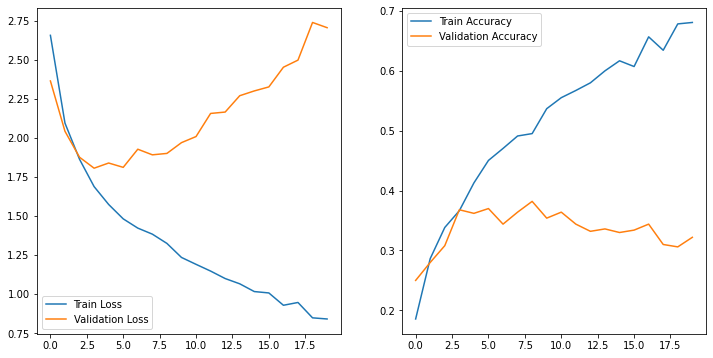

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")

plt.legend()

In [ ]:
tf.keras.utils.plot_model(combined_model, show_shapes=True)

We have achieved a validation accuracy around 30% although the training accuracy is as high as 67%. This indicated that our model overfits to the training data and fails to generalize. This assumption is supported by the graphs that showing the widening of the gap between the loss and accuracy values of train and validation data.

The evaluation of the model with the test set results in an accuracy of 35%.

Although we have tried different techniques such as Dropout, Data Augmentation, Different Poolings, activation functions and model structures with different parameters, we could not solve the overfitting problem, thus we could not get healthy results.